In [3]:
!pip install jovian --upgrade --quiet

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader,random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import jovian

In [5]:
dataset=CIFAR10(root='data/',download=True,transform=T.ToTensor())
test_dataset=CIFAR10(root='data/',train=False,transform=T.ToTensor())

Extracting data/cifar-10-python.tar.gz to data/


In [6]:
len(dataset)

50000

In [7]:
classes=dataset.classes

In [8]:
def show_img(x):
    img,lab=x
    plt.imshow(img.permute(1,2,0))
    print(classes[lab])
    print(img.shape)

frog
torch.Size([3, 32, 32])


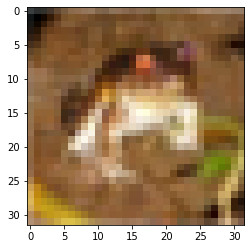

In [9]:
show_img(dataset[0])

In [10]:
val_size=int(0.1*len(dataset))
train_size=int(len(dataset)-val_size)
batch_size=128
train_data,val_data=random_split(dataset,[train_size,val_size])
len(train_data)

45000

In [11]:
train_loader=DataLoader(train_data,batch_size,pin_memory=True,num_workers=3)

In [12]:
val_loader=DataLoader(val_data,batch_size*2,pin_memory=True,num_workers=3)

In [13]:
def show_batch(xb):
    img,lab=xb
    fig,ax=plt.subplots(figsize=(12,12))
    ax.set_xticks([]),ax.set_yticks([])
    ax.imshow(make_grid(img[:64],nrow=8).permute(1,2,0))

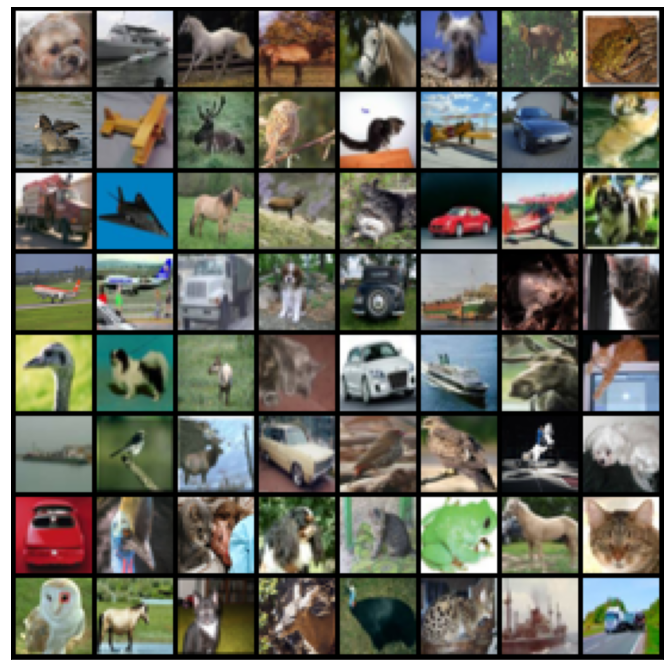

In [14]:
for x in train_loader:
    show_batch(x)
    break

In [15]:
def accuracy(out,targets):
    _,preds=torch.max(out,dim=1)
    return torch.tensor(torch.sum(preds==targets).item()/len(targets))

class ImageClassificationBase(nn.Module):
    def training_step(self,xb):
        img,labels=xb
        out=self(img)
        loss=F.cross_entropy(out,labels)
        return loss
    def validation_step(self,xb):
        img,labels=xb
        out=self(img)
        loss=F.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {'val_loss':loss,'val_acc':acc}
    def validation_step_end(self,outputs):
        losses=[x['val_loss'] for x in outputs]
        accs=[x['val_acc'] for x in outputs]
        val_loss=torch.stack(losses).mean()
        val_acc=torch.stack(accs).mean()
        return {'val_loss':val_loss.item(),'val_acc':val_acc.item()}
    def epoch_end(self,epoch,output):
        print("Epoch[{}] : train_loss:{:.4f}, val_loss:{:.4f}, val_acc:{:.2f}".format(epoch,output['train_loss'],output['val_loss'],output['val_acc']))

In [16]:
class CIFAR10cnn(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear=nn.Sequential(
            # 3x32x32
            nn.Conv2d(3,32,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            
            nn.MaxPool2d(2,2),
            #64x16x16
            nn.Conv2d(64,128,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.Conv2d(128,256,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # 256x8x8
            
            nn.Conv2d(256,512,kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # 512x4x4
            
            nn.Flatten(),
            nn.Linear(512*4*4,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,10))
    def forward(self,batch):
        return self.linear(batch)

In [17]:
model=CIFAR10cnn()
model

CIFAR10cnn(
  (linear): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten()
    (14): Linear(in_features=8192, out_features=512, bias=True)
    (15): ReLU()
    (16): Linear(in_features=512, out_features=128, bias=True)
    (17): ReLU()
    (18): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [18]:
def get_default_device():
    if torch.cuda.is_available():
        device=torch.device('cuda')
    else:
        device=torch.device('cpu')
    return device

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    
    def __len__(self):
        return len(self.dl)

In [19]:
device=get_default_device()
device

device(type='cuda')

In [20]:
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)
model=to_device(model,device)

In [21]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    out=[model.validation_step(val) for val in val_loader]
    res=model.validation_step_end(out)
    return res

def fit(model,train_loader,val_loader,epochs=10,lr=0.001,opt_func=torch.optim.Adam):
    opt=opt_func(model.parameters(),lr)
    history=[]
    
    for epoch in range(epochs):
        model.train()
        train_losses=[]
        for batch in train_loader:
            loss=model.training_step(batch)
            loss.backward()
            train_losses.append(loss)
            opt.step()
            opt.zero_grad()
        result=evaluate(model,val_loader)
        result['train_loss']=torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [22]:
hist=[evaluate(model,val_loader)]
hist

[{'val_loss': 2.30375337600708, 'val_acc': 0.09941406548023224}]

In [23]:
epochs=8
lr=0.0001
hist=fit(model,train_loader,val_loader,epochs,lr)

Epoch[0] : train_loss:1.8819, val_loss:1.5882, val_acc:0.42
Epoch[1] : train_loss:1.4967, val_loss:1.4081, val_acc:0.48
Epoch[2] : train_loss:1.3614, val_loss:1.2957, val_acc:0.53
Epoch[3] : train_loss:1.2722, val_loss:1.2200, val_acc:0.56
Epoch[4] : train_loss:1.1881, val_loss:1.1492, val_acc:0.59
Epoch[5] : train_loss:1.1077, val_loss:1.0818, val_acc:0.62
Epoch[6] : train_loss:1.0340, val_loss:1.0318, val_acc:0.63
Epoch[7] : train_loss:0.9683, val_loss:0.9874, val_acc:0.65


In [24]:
epochs=8
lr=0.0001
hist+=fit(model,train_loader,val_loader,epochs,lr)

Epoch[0] : train_loss:0.9117, val_loss:0.9465, val_acc:0.66
Epoch[1] : train_loss:0.8559, val_loss:0.9167, val_acc:0.68
Epoch[2] : train_loss:0.8071, val_loss:0.8952, val_acc:0.69
Epoch[3] : train_loss:0.7600, val_loss:0.8832, val_acc:0.70
Epoch[4] : train_loss:0.7136, val_loss:0.8716, val_acc:0.70
Epoch[5] : train_loss:0.6679, val_loss:0.8720, val_acc:0.71
Epoch[6] : train_loss:0.6261, val_loss:0.8770, val_acc:0.71
Epoch[7] : train_loss:0.5835, val_loss:0.8757, val_acc:0.72


In [25]:
epochs=4
lr=0.001
hist+=fit(model,train_loader,val_loader,epochs,lr)

Epoch[0] : train_loss:1.0836, val_loss:0.9258, val_acc:0.67
Epoch[1] : train_loss:0.7666, val_loss:0.8572, val_acc:0.70
Epoch[2] : train_loss:0.6231, val_loss:0.8317, val_acc:0.72
Epoch[3] : train_loss:0.4993, val_loss:0.9913, val_acc:0.70


In [26]:
epochs=6
lr=0.0001
hist+=fit(model,train_loader,val_loader,epochs,lr)

Epoch[0] : train_loss:0.2567, val_loss:0.8349, val_acc:0.77
Epoch[1] : train_loss:0.1592, val_loss:0.9495, val_acc:0.77
Epoch[2] : train_loss:0.0964, val_loss:1.1273, val_acc:0.77
Epoch[3] : train_loss:0.0521, val_loss:1.3458, val_acc:0.77
Epoch[4] : train_loss:0.0261, val_loss:1.5793, val_acc:0.77
Epoch[5] : train_loss:0.0178, val_loss:1.7527, val_acc:0.76


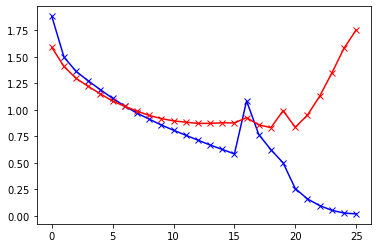

In [27]:
t_loss=[x['train_loss'] for x in hist]
v_loss=[x['val_loss'] for x in hist]
plt.plot(t_loss,'-bx')
plt.plot(v_loss,'-rx')
plt.show()

***we can see that after about the fifth epoch our model started to overfit the data as ot kept on minimizing the train loss but that cause the val loss to grow so we can stop at the 16th epoch to geta better generalized model***

In [28]:
torch.save(model.state_dict(),'cifar10cnn.pth')

In [29]:
test_loader=DataLoader(test_dataset,batch_size*2)
test_loader=DeviceDataLoader(test_loader,device)
hist_test=evaluate(model,test_loader)

In [30]:
hist_test

{'val_loss': 1.8854879140853882, 'val_acc': 0.758593738079071}

In [31]:
jovian.log_hyperparams(epochs=20,lr=0.0001)

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.


In [ ]:
jovian.commit(project='CIFAR10-CNN',outputs=['cifar10cnn.pth'])